In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from mpmath import mp
import scipy.special as sc
from functools import partial
from scipy.integrate import quad
import sympy as smp

In [2]:
def τ(w_i, w_j, x, y):
    """j invades i, starting at freq y and reaching freq x
    """
    return np.log((x * (1-y)) / ((1-x) * y)) / np.log(w_j / w_i)


def T(N, μ1, μ2, δ, w_euwt, w_anwt, w_anmt, w_eumt, x_0=0, PLOT_N=False, PLOT_δ=False ):
    assert w_euwt < w_anwt < w_anmt < w_eumt
    p_euwt_eumt = 1 - (1 - 2*((w_eumt - w_euwt) / w_euwt) * μ1)**N
    p_euwt_anwt = 1 - (1 - 2*((w_anwt - w_euwt) / w_euwt) * δ)**N
    p_anwt_anmt = 1 - (1 - 2*((w_anmt - w_anwt) / w_anwt) * μ2)**N
    # no fix of anmt - use w_anwt; 
    δ=np.array([δ])
    if δ.all() == 0:
        p_anmt_eumt = 1
    else: p_anmt_eumt = 1 - (1 - 2*((w_eumt - w_anwt) / w_anwt) * δ)**N # N doesnt make sense here...
    

    
    p_min = 1 - (1 - p_euwt_eumt) * (1 - p_euwt_anwt)
    p_a = p_euwt_anwt / (p_euwt_eumt + p_euwt_anwt)
    
    # 
    τ_euwt_eumt = τ(w_euwt, w_eumt, x=0.95, y=np.maximum(x_0,1/N))
    # start with one or delta*N individuals  # why delta*N and not 2*s*delta*N
    τ_euwt_anwt = τ(w_euwt, w_anwt, x=1-1/N, y=np.maximum(δ, 1/N)) 
    # 
    τ_anwt_anmt = τ(w_anwt, w_anmt, x=1-1/N, y=np.maximum(μ2,1/N))
     # no fix of anmt - use w_anwt; # start with one or delta*N individuals
    τ_anmt_eumt = τ(w_anwt, w_eumt, x=0.95, y=np.maximum(δ, 1/N))
    
    T_m = 1/p_min + τ_euwt_eumt
    T_a = (
        1/p_min 
        + 1/p_anwt_anmt 
        + 1/p_anmt_eumt 
        + τ_euwt_anwt  
#        + τ_anwt_anmt  # no fix of anmt, don't count
        + τ_anmt_eumt 
    )             
    T =  p_a * T_a + (1 - p_a) * T_m
    
    if PLOT_N:
        plt.plot(N, 1/p_min, label='T_min', color='blue')
        plt.plot(N, 1/p_anwt_anmt, label='T_anwt_anmt', color='orange' )
        plt.plot(N, 1/p_anmt_eumt, label='T_anmt_eumt', color='red' )
        plt.plot(N, τ_euwt_anwt, '--', label='τ_euwt_anwt', color='orange')
        plt.plot(N, τ_anwt_anmt, '--', label='τ_anwt_anmt', color='red')
        plt.plot(N, τ_anmt_eumt, '--', label='τ_anmt_eumt', color='purple')
        plt.legend()
#         plt.yscale('log')
        plt.xscale('log')
        plt.ylim(0, None)
        
    if PLOT_δ:
        plt.plot(δ, 1/p_min, label='T_min', color='blue')
        plt.plot(δ, [1/p_anwt_anmt for d in δ], label='T_anwt_anmt', color='orange' )
        plt.plot(δ, 1/p_anmt_eumt, label='T_anmt_eumt', color='red' )
        plt.plot(δ, τ_euwt_anwt, '--', label='τ_euwt_anwt', color='orange')
        plt.plot(δ, [τ_anwt_anmt for d in δ], '--', label='τ_anwt_anmt', color='red')
        plt.plot(δ, τ_anmt_eumt, '--', label='τ_anmt_eumt', color='purple')
        plt.legend()
#         plt.yscale('log')
        plt.xscale('log')
        plt.ylim(0, None)
    return T

In [3]:
def integral(f, N, s, a, b):
    f = partial(f, N, s)    
    return quad(f, a, b)[0] #  limit=100

def mpintegral(f, N, s, a, b):
    f = partial(f, N, s)    
    return mp.quad(f, [a, b], verbose=False)

def I1(N, s, x):
    if x == 1:
        return 0
    S = 2*N*s
#     return np.expm1(S*x) * (np.exp(-S*x) - np.exp(-S)) / (x * (1-x)) # first term overflow so I rearranged:
    return (np.exp(-S) - np.exp(-S*x) - np.expm1(-S*(1-x))) / (x * (1-x))

def I2(N, s, x):
    if x == 0:
        return 0
    S = 2*N*s
    # use mp instad of np for high precision due to expm1(S*x)
    return -mp.expm1(S*x) * mp.expm1(-S*x) / (x * (1-x)) 

def p_kimura(N, s, x0=None):
    if x0 is None: x0 = 1 / N
    S = 2 * N * s
    numer = np.expm1(-S * x0)
    denom = np.expm1(-S)
    return numer / denom

@np.vectorize
def τ_kimura(N, w_i, w_j, x, y):
    """j invades i, starting at freq y and reaching freq x
    """
    s = (w_j - w_i) / w_i    
    x0, max_x, min_x = y, x, 0
    S = 2 * N * s
    J1 = -1.0 / (s * np.expm1(-S)) * integral(I1, N, s, x0, max_x)
    u = p_kimura(N, s, x0)
    # use mpintegral with mp.quad for high precision due to expm1(S*x) in I2
    J2 = -1.0 / (s * np.expm1(-S)) * mpintegral(I2, N, s, min_x, x0)
#     print(J1, J2, u, 1-u)
    return J1 + ((1 - u) / u) * J2 # eq 17 in Kimura & Ohta, Genetics 1969


In [4]:
def T_kimura(N, μ1, μ2, δ, w_euwt, w_anwt, w_anmt, w_eumt, x_0=0):
    assert w_euwt < w_anwt < w_anmt < w_eumt
    p_euwt_eumt = 1 - (1 - p_kimura(N, (w_eumt - w_euwt) / w_euwt) * μ1)**N
    p_euwt_anwt = 1 - (1 - p_kimura(N, (w_anwt - w_euwt) / w_euwt) * δ)**N
    p_anwt_anmt = 1 - (1 - p_kimura(N, (w_anmt - w_anwt) / w_anwt) * μ2)**N
    # no fix of anmt - use w_anwt; 
#     p_anmt_eumt = 1 - (1 - p_kimura(N, (w_eumt - w_anwt) / w_anwt) * δ)**N # N doesnt make sense here but it doesnt seem to matter
    
    δ=np.array([δ])
    if δ.all() == 0:
        p_anmt_eumt = 1
    else: p_anmt_eumt = 1 - (1 - p_kimura(N, (w_eumt - w_anwt) / w_anwt) * δ)**N  # N doesnt make sense here...
    

    p_min = 1 - (1 - p_euwt_eumt) * (1 - p_euwt_anwt)
    p_a = p_euwt_anwt / (p_euwt_eumt + p_euwt_anwt)
    
    # τ_kimura(N, s, x0=None, max_x=1, min_x=0)
    τ_euwt_eumt = τ_kimura(N, w_euwt, w_eumt, x=0.95, y=np.maximum(x_0,1/N))
    # start with one or delta*N individuals
    τ_euwt_anwt = τ_kimura(N, w_euwt, w_anwt, x=1-1/N, y=np.maximum(δ, 1/N)) 
    # no fix of anmt, don't count
    # τ_anwt_anmt = τ_kimura(N, w_anwt, w_anmt, x=1-1/N, y=1/N)
    # no fix of anmt - use w_anwt; # start with one or delta*N individuals
    τ_anmt_eumt = τ_kimura(N, w_anwt, w_eumt, x=0.95, y=np.maximum(δ, 1/N))
    
    T_m = 1/p_min + τ_euwt_eumt
    T_a = (
        # euwt->anwt
        1/p_min 
        + τ_euwt_anwt 
        # anwt->anmt
        + 1/p_anwt_anmt 
#         + τ_anwt_anmt  # no fix of anmt, don't count
        # anmt->eumt
        + 1/p_anmt_eumt
        + τ_anmt_eumt 
    )             
    T =  p_a * T_a + (1 - p_a) * T_m
    return T

In [5]:
def IK1(α, p, x):
    return 2*(mp.coth(p*α)-mp.coth(α))*mp.power(mp.sinh(x*α),2)/((1-x)*x*α)

def IK2(α, p, x):
    return 2*mp.csch(α)*mp.sinh(x*α)*mp.sinh(α*(1-x))/(α*x*(1-x))

@np.vectorize
def τ_Kim(N, w_i, w_j, p, fc):
    s = (w_j - w_i) / w_i
    α = 2*N*s
    i1=partial(IK1, α, p)
    i2=partial(IK2, α, p)
    return N*(mp.quad(i1,[0,p])+mp.quad(i2,[p,fc]))*2

In [6]:
def tβs_1(α, β, p, x):
    num_1 = mp.power(4, β)*mp.power(α*x, 2*β-1)*mp.exp(2*x*α)
    num_2 = (mp.gammainc(1-2*β,2*α)-mp.gammainc(1-2*β,2*α*p))*mp.power(mp.gammainc(1-2*β)-mp.gammainc(1-2*β,2*α*x),2)
    denom = (-1+x)*(mp.gammainc(1-2*β)-mp.gammainc(1-2*β,2*α))*(mp.gammainc(1-2*β)-mp.gammainc(1-2*β,2*p*α))
    return num_1*num_2/denom

def tβs_2(α, β, p, x):
    num_1 = 2*mp.exp(2*x*α)*(mp.power(x, 2*β)*mp.expint(2*β, 2*α)-x*mp.expint(2*β, 2*x*α))
    num_2 = (mp.gammainc(1-2*β)-mp.gammainc(1-2*β,2*α*x))
    denom = (-1+x)*x*(mp.gammainc(1-2*β)-mp.gammainc(1-2*β,2*α))
    return num_1*num_2/denom

def tβl_1(α, β, p, x):
    num_1 = 2*mp.power(x, 2*β-1)*mp.exp(2*x*α)
    num_2 = (mp.power(p, 1-2*β)*mp.expint(2*β, 2*p*α)-mp.expint(2*β, 2*α))
    denom = (1-x)
    return num_1*num_2/denom

def tβl_2(α, β, p, x):
    num_1 = 2*mp.exp(2*x*α)
    num_2 = (mp.expint(2*β, 2*x*α)-mp.power(x, 2*β-1)*mp.expint(2*β, 2*α))
    denom = (1-x)
    return num_1*num_2/denom


@np.vectorize
def t_rec(N, rate, w_i, w_j, p, fc=1):
    """j invades i, starting at freq p and reaching fc"""
    s = (w_j - w_i) / w_i   
    α = 2*N*s
    β = 2*N*rate
    if 0 <= β < 1/2:
        t1 = partial(tβs_1, α, β, p)
        t2 = partial(tβs_2, α, β, p)
        return 2*N*(mp.quad(t1,[0,p])+mp.quad(t2,[p,fc]))
    else:
        t1 = partial(tβl_1, α, β, p)
        t2 = partial(tβl_2, α, β, p)
        return 2*N*(mp.quad(t1,[0,p])+mp.quad(t2,[p,fc]))

In [7]:
def T_rec(N, μ1, μ2, δ, w_euwt, w_anwt, w_anmt, w_eumt, x_0=0, fc=.95):
    assert w_euwt < w_anwt < w_anmt < w_eumt
    p_euwt_eumt = 1 - (1 - p_kimura(N, (w_eumt - w_euwt) / w_euwt) * μ1)**N
    p_euwt_anwt = 1 - (1 - p_kimura(N, (w_anwt - w_euwt) / w_euwt) * δ)**N
    p_anwt_anmt = 1 - (1 - p_kimura(N, (w_anmt - w_anwt) / w_anwt) * μ2)**N
    # no fix of anmt - use w_anwt; 
#     p_anmt_eumt = 1 - (1 - p_kimura(N, (w_eumt - w_anwt) / w_anwt) * δ)**N # N doesnt make sense here but it doesnt seem to matter
    
    δ=np.array([δ])
    if δ.all() == 0:
        p_anmt_eumt = 1
    else: p_anmt_eumt = 1 - (1 - p_kimura(N, (w_eumt - w_anwt) / w_anwt) * δ)**N  # N doesnt make sense here...
    

    p_min = 1 - (1 - p_euwt_eumt) * (1 - p_euwt_anwt)
    p_a = p_euwt_anwt / (p_euwt_eumt + p_euwt_anwt)
    
    # τ_kimura(N, s, x0=None, max_x=1, min_x=0)
    τ_euwt_eumt = t_rec(N, μ1, w_euwt, w_eumt, p=np.maximum(x_0,1/N),fc=fc)
    # start with one or delta*N individuals
    τ_euwt_anwt = t_rec(N, δ, w_euwt, w_anwt, p=np.maximum(δ, 1/N),fc=fc) 
    # no fix of anmt, don't count
    # τ_anwt_anmt = τ_kimura(N, w_anwt, w_anmt, x=1-1/N, y=1/N)
    # no fix of anmt - use w_anwt; # start with one or delta*N individuals
    τ_anmt_eumt = t_rec(N, δ, w_anwt, w_eumt, p=np.maximum(δ, 1/N),fc=fc)
    
    T_m = 1/p_min + τ_euwt_eumt
    T_a = (
        # euwt->anwt
        1/p_min 
        + τ_euwt_anwt 
        # anwt->anmt
        + 1/p_anwt_anmt 
#         + τ_anwt_anmt  # no fix of anmt, don't count
        # anmt->eumt
        + 1/p_anmt_eumt
        + τ_anmt_eumt 
    )             
    T =  p_a * T_a + (1 - p_a) * T_m
    return T

# Comparison:

## Population size

In [8]:
Nm58, msim_noaneuN_manu58=np.load('msim_noaneuN_manu58.npy',allow_pickle=True)
Nm58 = Nm58.astype('float64')

msim_noaneuN58=np.array([x for x in msim_noaneuN_manu58[0]])
#Nm58=np.logspace(5, 8, 50)

In [9]:
N, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt = Nm58, 9.6e-08, 0, 1, 1.021, 1.025, 1.028

In [10]:
%timeit τ_kimura(N, w_euwt, w_eumt, x=.95, y=1/N)
%timeit t_rec(N, μ , w_euwt, w_eumt, 1/N, fc=0.95)

388 ms ± 8.55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8.95 s ± 82.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
τ__= τ(w_euwt, w_eumt, .95, 1/N)
τ_K= τ_kimura(N, w_euwt, w_eumt, x=.95, y=1/N)
τ_r = t_rec(N, μ , w_euwt, w_eumt, 1/N, fc=0.95)

In [12]:
τ_Ki = τ_Kim(N, w_euwt, w_eumt, 1/N, .95)

In [20]:
p0 = 1 - (1 - p_kimura(N, (w_eumt - w_euwt) / w_euwt) * 9.6e-08)**N
p1 = 1 - (1 - p_kimura(N, (w_anwt - w_euwt) / w_euwt) * δ)**N
p_mint = 1 - (1 - p0) * (1 - p1)
p_at= p1 / (p0 + p1)

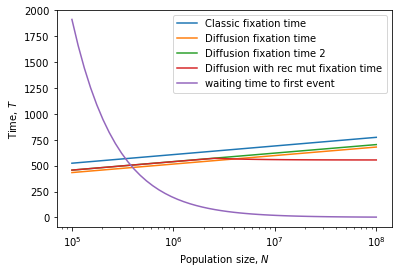

In [29]:
plt.plot(N, τ__, label='Classic fixation time')
plt.plot(N, τ_K, label='Diffusion fixation time')
plt.plot(N, τ_Ki, label='Diffusion fixation time 2')
plt.plot(N, τ_r, label='Diffusion with rec mut fixation time')


plt.plot(N, 1/p_mint, label='waiting time to first event')


plt.xscale('log')
#plt.yscale('log')
#plt.xlim([1e5,2e5])
#plt.ylim([400,600])
plt.xlabel("Population size, $N$")
plt.ylabel('Time, $T$')
plt.legend();

In [28]:
T__=T(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt)#, x_0=35*μ)
T_K=T_kimura(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt)#, x_0=35*μ)
T_r=T_rec(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt, fc=.95)#, x_0=35*μ)

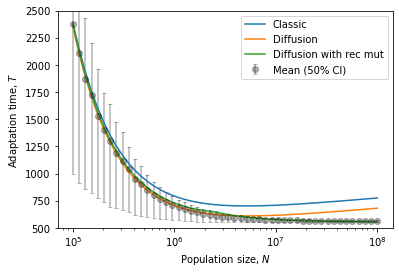

In [34]:
mean = msim_noaneuN58.mean(axis=1)
low = np.percentile(msim_noaneuN58, 25, axis=1)
high = np.percentile(msim_noaneuN58, 75, axis=1)
plt.errorbar(N, mean, [(mean-low), (high-mean)],fmt='o', color='k', capsize=2, label='Mean (50% CI)', alpha=.3)

plt.plot(N, T__, label='Classic')
plt.plot(N, T_K, label='Diffusion')
plt.plot(N, T_r, label='Diffusion with rec mut')

plt.xscale('log')
#plt.yscale('log')
#plt.xlim([1e5,1e7])
plt.ylim([500,2500])
plt.xlabel("Population size, $N$")
plt.ylabel('Adaptation time, $T$')
plt.legend()
#plt.savefig('Diffusion with rec mutation_N.pdf');

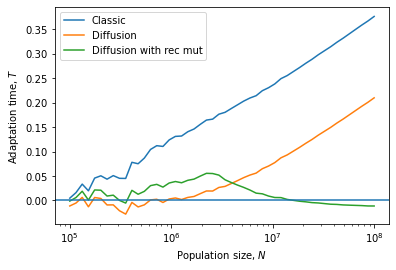

In [41]:
plt.plot(N, (T__-mean)/mean, label='Classic')
plt.plot(N, (T_K-mean)/mean, label='Diffusion')
plt.plot(N, (T_r-mean)/mean, label='Diffusion with rec mut')
plt.axhline(0)

plt.xscale('log')
#plt.yscale('log')
#plt.xlim([1e7,1e8])
#plt.ylim([525,600])
plt.xlabel("Population size, $N$")
plt.ylabel('Adaptation time, $T$')
plt.legend();

## Mutation rate

In [75]:
μm, msim_noaneuμ_manu=np.load('msim_noaneuμ_manu.npy',allow_pickle=True)
μm = μm.astype('float64')

msim_noaneuμ_manu=np.array([x for x in msim_noaneuμ_manu[0]])

In [76]:
N, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt = 6e6, μm, 0, 1, 1.021,1.025, 1.028

In [77]:
τ__ = [τ(w_euwt, w_eumt, .95, 1/N) for x in μ]
τ_K = [τ_kimura(N, w_euwt, w_eumt, x=.95, y=1/N) for x in μ]
τ_r = t_rec(N, μ , w_euwt, w_eumt, 1/N, fc=0.95)
τ_Ki = [τ_Kim(N, w_euwt, w_eumt, 1/N, .95) for x in μ]

In [78]:
p0 = 1 - (1 - p_kimura(N, (w_eumt - w_euwt) / w_euwt) * μ)**N
p1 = 1 - (1 - p_kimura(N, (w_anwt - w_euwt) / w_euwt) * δ)**N
p_mint = 1 - (1 - p0) * (1 - p1)
p_at= p1 / (p0 + p1)

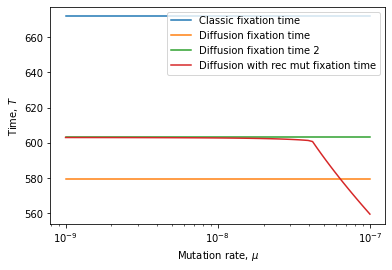

In [79]:
plt.plot(μ, τ__, label='Classic fixation time')
plt.plot(μ, τ_K, label='Diffusion fixation time')
plt.plot(μ, τ_Ki, label='Diffusion fixation time 2')
plt.plot(μ, τ_r, label='Diffusion with rec mut fixation time')
#plt.plot(μ, 1/p_mint, label='waiting time to first event')
#plt.plot(μ, 1/p_mint+τ__, label='waiting time to first event+classic FT')
#plt.plot(μ, 1/p_mint+τ_r, label='waiting time to first event+rec mut FT')

plt.xscale('log')
#plt.yscale('log')
#plt.xlim([1e7,1e8])
#plt.ylim([500,700])
plt.xlabel("Mutation rate, $μ$")
plt.ylabel('Time, $T$')
plt.legend();

In [65]:
T__ = T(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt) #, x_0=35*μ)
T_ = T_kimura(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt) #, x_0=35*μ)
T_r = T_rec(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt, fc=.95) #, x_0=35*μ)

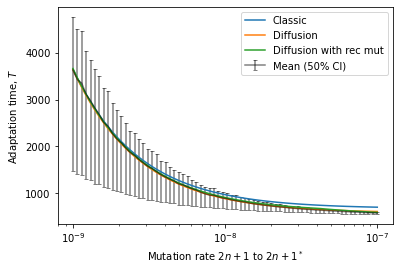

In [66]:
mean = np.mean(msim_noaneuμ_manu, axis=1)
low = np.percentile(msim_noaneuμ_manu, 25, axis=1)
high = np.percentile(msim_noaneuμ_manu, 75, axis=1)
plt.errorbar(μ, mean, [mean-low, high-mean], color='k', capsize=2, label='Mean (50% CI)', alpha=.5)

plt.plot(μ, T__, label='Classic')
plt.plot(μ, T_, label='Diffusion')
plt.plot(μ, T_r, label='Diffusion with rec mut')
#plt.plot(μ, 1/p_mint+2*τ_r, label='waiting time to first event, no sel+rec mut FT')

plt.xscale('log')
#plt.yscale('log')
#plt.xlim([3e-9,1e-7])
#plt.ylim([500,1700])
plt.xlabel("Mutation rate $2n+1$ to $2n+1^*$")
plt.ylabel('Adaptation time, $T$')
plt.legend()
plt.savefig('Diffusion with mutation_mu2.pdf');

In [80]:
μm68, msim_noaneuμ68_manu=np.load('msim_noaneuμ68_manu.npy',allow_pickle=True)
μm68= μm68.astype('float64')

msim_noaneuμ68_manu=np.array([x for x in msim_noaneuμ68_manu[0]])

In [81]:
N, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt = 6e6, μm68, 0, 1, 1.021,1.025, 1.028

In [82]:
τ__ = [τ(w_euwt, w_eumt, .95, 1/N) for x in μ]
τ_K = [τ_kimura(N, w_euwt, w_eumt, x=.95, y=1/N) for x in μ]
τ_r = t_rec(N, μ , w_euwt, w_eumt, 1/N, fc=0.95)
τ_Ki = [τ_Kim(N, w_euwt, w_eumt, 1/N, .95) for x in μ]

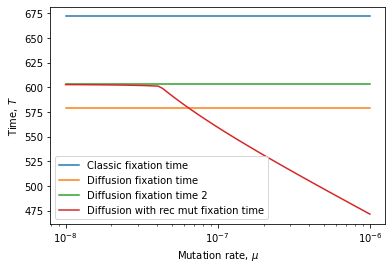

In [83]:
plt.plot(μ, τ__, label='Classic fixation time')
plt.plot(μ, τ_K, label='Diffusion fixation time')
plt.plot(μ, τ_Ki, label='Diffusion fixation time 2')
plt.plot(μ, τ_r, label='Diffusion with rec mut fixation time')
#plt.plot(μ, 1/p_mint, label='waiting time to first event')
#plt.plot(μ, 1/p_mint+τ__, label='waiting time to first event+classic FT')
#plt.plot(μ, 1/p_mint+τ_r, label='waiting time to first event+rec mut FT')

plt.xscale('log')
#plt.yscale('log')
#plt.xlim([1e7,1e8])
#plt.ylim([500,700])
plt.xlabel("Mutation rate, $μ$")
plt.ylabel('Time, $T$')
plt.legend();

In [84]:
T__ = T(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt) #, x_0=35*μ)
T_ = T_kimura(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt) #, x_0=35*μ)
T_r = T_rec(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt, fc=.95) #, x_0=35*μ)

In [61]:
T_r68=T_r

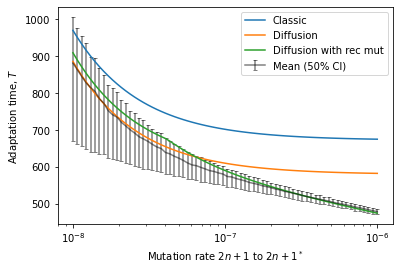

In [86]:
mean = np.mean(msim_noaneuμ68_manu, axis=1)
low = np.percentile(msim_noaneuμ68_manu, 25, axis=1)
high = np.percentile(msim_noaneuμ68_manu, 75, axis=1)
plt.errorbar(μ, mean, [(mean-low), (high-mean)], color='k', capsize=2, label='Mean (50% CI)', alpha=.5)

plt.plot(μ, T__, label='Classic')
plt.plot(μ, T_, label='Diffusion')
plt.plot(μ, T_r, label='Diffusion with rec mut')

plt.xscale('log')
#plt.yscale('log')
#plt.xlim([1e-8,1e-7])
#plt.ylim([530,1000])
plt.xlabel("Mutation rate $2n+1$ to $2n+1^*$")
plt.ylabel('Adaptation time, $T$')
plt.legend()
plt.savefig('Diffusion with mutation_mu.pdf');